# Indicator of heavy rainfall


## Return value approach



In [1]:
%matplotlib inline

from pathlib import Path
from datetime import date

import numba
import rasterio
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from scipy import stats
from numba import jit, prange, float32
from cartopy import crs

import weather_ecmwf
import population_tools

from config import DATA_SRC, WEATHER_SRC, POP_DATA_SRC

In [2]:
MAX_YEAR = 2017
REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

POP_FILE = POP_DATA_SRC / 'population_count_2000-2020_eightres.nc'

RESULTS_FOLDER = Path('./results/lancet2018/global/1.5 extreme rain')
EXTREME_RAIN_THRESHOLD = 1.64


In [3]:
# from dask.distributed import Client
# client = Client()
# client

# Daily rainfall approach - reproduce 2015 method

> Watts et. al 2015: Figure 7 shows estimates of extreme precipitation events (events exceeding 10 year return period) under the RCP8.5 (high-emission) scenario. We estimate that there would be around 2 billion additional extreme rainfall exposure events annually (individuals exposed once or multiple times during any year). Flood risk was estimated by defining a flood event to be a 5 day precipitation total exceeding the 10 year return level in the hisotircal period (1986-2005).


In [4]:
ppt_5day = xr.open_mfdataset(str(WEATHER_SRC / 'ecmwf' / '5day_precipitation'/ '*_ppt_5day.nc'), 
#                               chunks={'latitude': 100, 'longitude': 100}
                            )

In [5]:
ppt_5day = ppt_5day.sel(time=slice('1980-01-01', f'{MAX_YEAR}-12-31'))

In [6]:
@jit(nopython=True, nogil=True)
def return_threshold_10_year(rain_ts):
    out = np.zeros((rain_ts.shape[0], rain_ts.shape[1]), dtype=np.float32)
    for i in range(rain_ts.shape[0]):
        for j in range(rain_ts.shape[1]):
            ts = rain_ts[i, j, :]
            ts = np.sort(ts[np.isfinite(ts)])
            N = len(ts)
            
            rank = np.arange(N) + 1
            #Gringorten 
            gringorten_dist = (rank - 0.44) / (N + 0.12)
            T = 1 / (1 - gringorten_dist)
            p = ts[T >= 10]
            out[i, j] = p.min()
    return out

In [7]:
def _get_ten_year_return(ppt_5day):
    ppt_baseline = ppt_5day.precipitation.sel(time=slice(f'{REFERENCE_YEAR_START}-01-01', 
                                                         f'{REFERENCE_YEAR_END}-12-31'))
    ppt_baseline = ppt_baseline.load()
    ppt_baseline = ppt_baseline.chunk(chunks={'latitude': 20, 'longitude': 20, 'time': -1})
    return xr.apply_ufunc(return_threshold_10_year,
                               ppt_baseline,
                               input_core_dims=[['time']],
                               output_core_dims=[[]],
                               dask='parallelized',
                               output_dtypes=[np.float64]
                               )
        
ten_yr_retn = _get_ten_year_return(ppt_5day)
ten_yr_retn.to_netcdf(DATA_SRC / 'lancet' / 'ten_year_ppt_return.nc')

In [8]:
ten_yr_retn = xr.open_dataarray(DATA_SRC / 'lancet' / 'ten_year_ppt_return.nc')

## Calculate events


Merge high rainfall events that occur on consecutive days, since these are really just one event

In [9]:
@jit("int64[:,:](b1[:,:,:])")
def fast_event_counts(events):
    
    last_slice = None
    accumulator = np.zeros(events.shape[1:], dtype=np.int64)
    counter = np.zeros(events.shape[1:], dtype=np.int64)
    
    for i in range(1, events.shape[0]):
        last_slice = events[i-1, :, :]
        data_slice = events[i, :, :]

        # Add to the sequence length counter at all positions
        # above threshold at prev time step
        accumulator[last_slice] += 1
        
        # End of sequence is where prev is true and current is false
        # True where prev and not current
        mask = last_slice & np.logical_not(data_slice)
        
        # Add one to the counter where the sequences are ending
        counter[mask] += 1
        # Reset the accumulator where current slice is empty
        accumulator[np.logical_not(data_slice)] = 0
            
    return counter



In [10]:
events = ppt_5day.precipitation > ten_yr_retn
events.name = 'precipitation_events'

In [11]:
events.to_netcdf(DATA_SRC / 'lancet' / 'ppt_ten_year_events.nc')

/home/jonathanchambers/Scratch/.conda/envs/lancet/lib/python3.6/site-packages/dask/local.py:255: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


In [12]:
def _fn(events_grp):
    counter = fast_event_counts(events_grp.values)
    return xr.DataArray(counter,
                        coords=[events.latitude.values,
                                events.longitude.values], 
                           dims=['latitude', 'longitude'],
                           name='event_count'
                          )

event_counts = events.groupby('time.year').apply(_fn, shortcut=True)

/home/jonathanchambers/Scratch/.conda/envs/lancet/lib/python3.6/site-packages/dask/local.py:255: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


In [13]:
event_counts.to_netcdf(DATA_SRC / 'lancet' / 'extreme_rain_event_counts.nc')

In [16]:
event_counts = xr.open_dataarray(DATA_SRC / 'lancet' / 'extreme_rain_event_counts.nc')

## Express global trend as 'events per km2' (map) and 'area affected by extreme rain'


In [14]:
# Calculate grid cell areas
delta_lon = events.longitude[1] - events.longitude[0]
earth_radius = 6371

areas = (np.sin(np.radians(events.latitude.values + delta_lon.values/2))
 - np.sin(np.radians(events.latitude.values - delta_lon.values/2))) * (np.radians(delta_lon.values)) * earth_radius**2

areas = xr.DataArray(areas, dims=['latitude'], coords={'latitude': events.latitude})


In [15]:
event_area_ts = (events * areas).sum(dim=['latitude', 'longitude']).compute()

/home/jonathanchambers/Scratch/.conda/envs/lancet/lib/python3.6/site-packages/dask/local.py:255: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


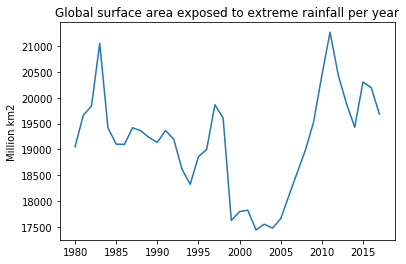

In [16]:
(event_area_ts.groupby('time.year').sum(dim='time')/ 1_000_000).plot()

# (event_area_ts[event_area_ts.time.dt.dayofyear > 5]/ 1_000_000).plot()
plt.title('Global surface area exposed to extreme rainfall per year')
plt.xlabel('')
plt.ylabel('Million km2')

plt.savefig(RESULTS_FOLDER / 'area_extreme_rainfall_ts.png', dpi=300)

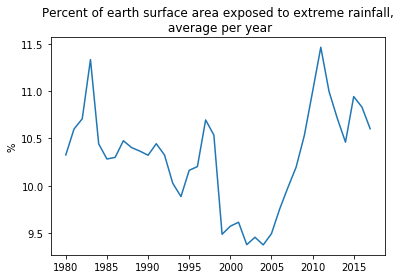

In [17]:
d = 100*event_area_ts[event_area_ts.time.dt.dayofyear > 5] / (510.1 * 1e6)
d.groupby('time.year').mean(dim='time').plot()

plt.title('Percent of earth surface area exposed to extreme rainfall,\n average per year')
plt.xlabel('')
plt.ylabel('%')

plt.savefig(RESULTS_FOLDER / 'pct_area_extreme_rainfall_ts.png', dpi=300)

In [18]:
import geopandas as gpd

COUNTRY_SHAPEFILE = DATA_SRC / 'GIS' / 'world'/ 'ne_50m_admin_0_countries' / 'ne_50m_admin_0_countries.shp'

# COUNTRY_POLY_SHP
COUNTRIES = gpd.read_file(str(COUNTRY_SHAPEFILE))
# Translate to match raster coordinates
COUNTRIES.geometry = COUNTRIES.translate(xoff=180)

COUNTRIES['dummy'] = 1

land_raster = population_tools.rasterize_data(events.isel(time=0), COUNTRIES, 'dummy')

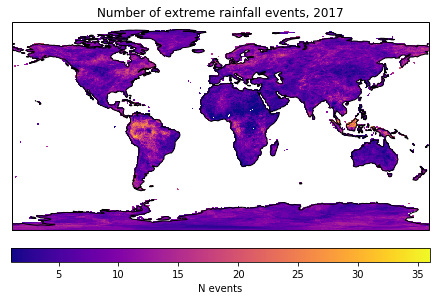

In [19]:
event_counts_mean = event_counts.sel(year=2017) * land_raster
event_counts_mean = event_counts_mean.where(event_counts_mean > 0)
event_counts_mean.name = 'N events'

f = plt.figure(constrained_layout=True)
ax = plt.subplot(projection=crs.PlateCarree())

p = event_counts_mean.plot.pcolormesh(
    cmap='plasma',
    transform=crs.PlateCarree(),
    cbar_kwargs={'orientation': 'horizontal',
                 'label': ''}
)
p.colorbar.set_label('N events')

ax.coastlines()
plt.title('Number of extreme rainfall events, 2017')

plt.savefig(RESULTS_FOLDER / 'n events 2017 map.png', 
            bbox_inches='tight', dpi=300)

## Calculate change in yearly event counts relative to 1986-2005 average

In [20]:
event_counts_change = (event_counts.sel(year=slice(2000,None)) - 
                       event_counts.sel(year=slice(REFERENCE_YEAR_START, REFERENCE_YEAR_END)).mean(dim='year'))

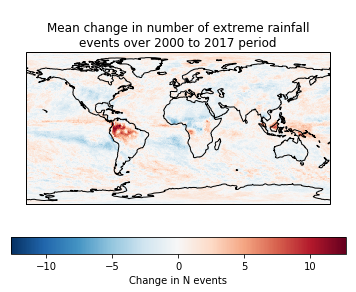

In [23]:
data = event_counts_change.mean(dim='year')

f = plt.figure( constrained_layout=False)
ax = plt.subplot(projection=crs.PlateCarree())
p = data.plot.pcolormesh(
    transform=crs.PlateCarree(),
    cbar_kwargs={'orientation':'horizontal','label':''}
)
p.colorbar.set_label('Change in N events')

ax.coastlines()

plt.title('''
Mean change in number of extreme rainfall
events over 2000 to 2017 period''')

plt.savefig(RESULTS_FOLDER / 'mean events change 2000-2017 map.png', 
            bbox_inches='tight', dpi=600)

plt.savefig(RESULTS_FOLDER / 'mean events change 2000-2017 map.pdf', 
            bbox_inches='tight')

Text(0.5,1,'Change in yearly mean area affected \n by extreme rainfall events')

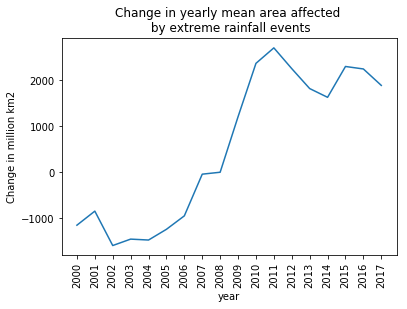

In [39]:
(event_counts_change * areas).mean(dim=['latitude', 'longitude']).plot()
plt.xticks(event_counts_change['year'], rotation=90)
plt.ylabel('Change in million km2')
plt.title('Change in yearly mean area affected \n by extreme rainfall events')
# plt.savefig(RESULTS_FOLDER / 'area_events_ts.png', bbox_inches='tight', dpi=300)

In [27]:
exposure_change_ts = population_tools.project_to_population(event_counts_change, get_ts=True).compute()
exposure_change_ts = exposure_change_ts.to_dataframe('exposures')

In [52]:
exposure_change_ts.to_dataframe('exposures').to_excel(RESULTS_FOLDER / 'exposures_change.xlsx')

In [3]:
exposure_change_ts = pd.read_excel(RESULTS_FOLDER / 'exposures_change.xlsx')

In [7]:
exposure_change_ts = exposure_change_ts.set_index('year')

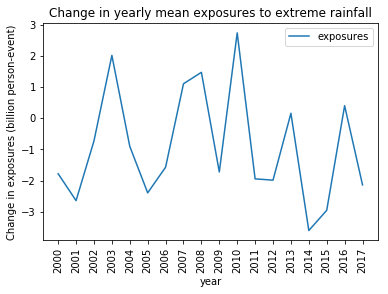

In [9]:
(exposure_change_ts/ 1e9).plot()
plt.xticks(exposure_change_ts.index, rotation=90)
plt.ylabel('Change in exposures (billion person-event)')
plt.title('Change in yearly mean exposures to extreme rainfall')
plt.savefig(RESULTS_FOLDER / 'exposures_change_ts.png', bbox_inches='tight', dpi=300)
plt.savefig(RESULTS_FOLDER / 'exposures_change_ts.pdf', bbox_inches='tight')

## Absolute number of exposures

> NOTE not sure whether to look at change or absolute, because we already take regional variation into account when we calculate the return value so does it make sense to again look at the mean number of events? Note also that because we coalesce events might have fewer events that area really long -> not actually better than having many small events.

In [67]:
event_counts = event_counts.astype(np.float64)
exposures_ts = population_tools.project_to_population(event_counts, get_ts=True).compute()

In [289]:
delta_lon = exposures_ts.longitude[1] - events_projected.longitude[0]
earth_radius = 6371

areas_proj = (np.sin(np.radians(events_projected.latitude.values + delta_lon.values/2))
 - np.sin(np.radians(events_projected.latitude.values - delta_lon.values/2))) * (np.radians(delta_lon.values)) * earth_radius**2

areas_proj = xr.DataArray(areas_proj, 
                          dims=['latitude'], 
                          coords={'latitude': events_projected.latitude})


In [71]:
exposures_ts.to_dataframe('exposures').to_excel(RESULTS_FOLDER / 'exposures.xlsx')

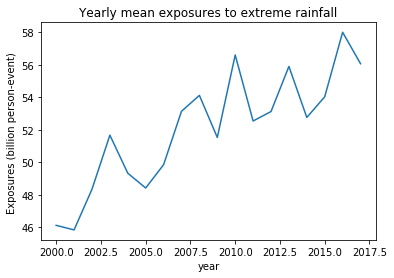

In [73]:
(exposures_ts / 1e9).plot()
plt.title('Yearly mean exposures to extreme rainfall')
plt.ylabel('Exposures (billion person-event) ')
plt.savefig(RESULTS_FOLDER / 'exposures_ts.png', bbox_inches='tight', dpi=300)